In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam, SGD
import scipy  #Used to upsample our image
import tensorflow as tf
import tensorflow_datasets as tfds  # to gather Malaria dataset

import os
import cv2
from PIL import Image
import numpy as np

In [2]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py
! wget -q https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/attention_modules.py

os.chdir('/content')
print("Current working directory", os.getcwd())

Current working directory /content


In [3]:
from utils import vision
from utils import utils
from utils import losses
from utils.attention_modules import Conv2DLayerBN, Conv2DLayerRes, ChannelGate, SpatialGate, CBAM

In [4]:
experiment = {
    'TYPE': 'train',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'GPU' or 'TPU'

    'IMAGE_SIZE': (128, 128),
    'INPUT_SHAPE': (128, 128, 3),
    'VALID_SIZE': 0.2,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation

    'BACKBONE': 'custom',        # 'custom', 'VGG16', 'VGG19' - default 'custom'
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 16,            # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 5,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 1e-4,

    'RECONS_LOSS': 'PERCEPTUAL',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'PERCEPTUAL_LAYERS': [5,8,13,18],    # [5,8,13,18], None
    'PERCEP_LOSS_MODEL': 'VGG19', # custom', 'VGG16', 'VGG19' - default 'VGG16'
    'PERP_LOSS_LAMBDA': 1,
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 500,

    'SAVE_WEIGHTS_PER_EPOCH': 10,
    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "tf_vae/BD67_dataset/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "tf_vae/BD67_dataset/images",
}

Load Malaria Cell Dataset

In [5]:
# Malaria Cell dataset from Kaggle
# https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

! pip install -q kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 98% 660M/675M [00:06<00:00, 65.3MB/s]
100% 675M/675M [00:06<00:00, 112MB/s] 


In [6]:
utils.unzip_data("/content/cell-images-for-detecting-malaria.zip")

! rm /content/cell-images-for-detecting-malaria.zip

In [7]:
DATASET_UNINFECTED = "/content/cell_images/Uninfected"
DATASET_INFECTED = "/content/cell_images/Parasitized"

Create Dataset pipeline for Uninfected dataset

In [8]:
LABELS = ["Uninfected", "Parasitized"]

In [9]:
uninfected_img_files = utils.get_image_file_list(DATASET_UNINFECTED, "png")
infected_img_files = utils.get_image_file_list(DATASET_INFECTED, "png")

print(f"Number of uninfected Malaria cell images: {len(uninfected_img_files)}")
print(f"Number of infected Malaria cell images: {len(infected_img_files)}")
print(f"Number of all Malaria cell images: {len(uninfected_img_files) + len(infected_img_files)}")

Number of uninfected Malaria cell images: 13779
Number of infected Malaria cell images: 13779
Number of all Malaria cell images: 27558


The total size of the dataset is too large to fit into ram, use only 10000 images for training, 1000 images for validation and 1000 images for testing.

In [10]:
import random as rnd

rnd.shuffle(uninfected_img_files)  # Shuffle all training img files
rnd.shuffle(infected_img_files)  # Shuffle all training img files

train_uninfected_img_files = uninfected_img_files[:5000]
train_infected_img_files = infected_img_files[:5000]

valid_uninfected_img_files = uninfected_img_files[5000:5500]
valid_infected_img_files = infected_img_files[5000:5500]

test_uninfected_img_files = uninfected_img_files[5500:6000]
test_infected_img_files = infected_img_files[5500:6000]

print("Uninfected and infected Malaria cell images were shuffled...")
print(f"Number of Training uninfected Malaria cell images: {len(train_uninfected_img_files)}")
print(f"Number of Training infected Malaria cell images: {len(train_infected_img_files)}")
print(f"Number of Training Malaria cell images: {len(train_uninfected_img_files) + len(train_infected_img_files)}")

print(f"\nNumber of Validatin uninfected Malaria cell images: {len(valid_uninfected_img_files)}")
print(f"Number of Validatin infected Malaria cell images: {len(valid_infected_img_files)}")
print(f"Number of Validatin Malaria cell images: {len(valid_uninfected_img_files) + len(valid_infected_img_files)}")

print(f"\nNumber of Testing uninfected Malaria cell images: {len(test_uninfected_img_files)}")
print(f"Number of Testing infected Malaria cell images: {len(test_infected_img_files)}")
print(f"Number of Testing all Malaria cell images: {len(test_uninfected_img_files) + len(test_infected_img_files)}")
print(f"\nNumber of All Malaria cell images: {len(train_uninfected_img_files) + len(train_infected_img_files) + len(test_uninfected_img_files) + len(test_infected_img_files)}")

Uninfected and infected Malaria cell images were shuffled...
Number of Training uninfected Malaria cell images: 5000
Number of Training infected Malaria cell images: 5000
Number of Training Malaria cell images: 10000

Number of Validatin uninfected Malaria cell images: 500
Number of Validatin infected Malaria cell images: 500
Number of Validatin Malaria cell images: 1000

Number of Testing uninfected Malaria cell images: 500
Number of Testing infected Malaria cell images: 500
Number of Testing all Malaria cell images: 1000

Number of All Malaria cell images: 11000


In [11]:
def load_and_preprocess_image(image_path):
    img = tf.io.read_file(image_path)

    # Decode the read file into a tensor & ensure 3 colour channels
    # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
    img = tf.image.decode_image(img, expand_animations = False)

    return utils._preprocess_image(img, img_size=experiment['IMAGE_SIZE'], scl=True)

In [12]:
import random as rnd

def create_dataset_pipeline(uninfected_img_files, infected_img_files):
    images = []
    labels = []

    for index, img_file in enumerate(uninfected_img_files):
        images.append(np.array(load_and_preprocess_image(img_file)))
        labels.append(0)

    for index, img_file in enumerate(infected_img_files):
        images.append(np.array(load_and_preprocess_image(img_file)))
        labels.append(1)

    indices = list(range(len(images)))
    rnd.shuffle(indices)

    shuffled_images = [images[i] for i in indices]
    shuffled_labels = [labels[i] for i in indices]

    X_train, y_train = np.array(shuffled_images), np.array(shuffled_labels)

    return X_train, y_train

In [13]:
X_train, y_train = create_dataset_pipeline(train_uninfected_img_files, train_infected_img_files)
X_test, y_test = create_dataset_pipeline(test_uninfected_img_files, test_infected_img_files)

In [14]:
def show_sample_images_from_dataset(images, labels):
    fig = plt.figure(figsize=(10, 10))

    for index, image in enumerate(images):  # Get first batch
      plt.subplot(4, 4, index + 1)
      plt.imshow(image[:, :, :])
      plt.title(f"Label: {LABELS[labels[index]]}")
      plt.axis('off')
      if index >= ((4*4)-1):
        break

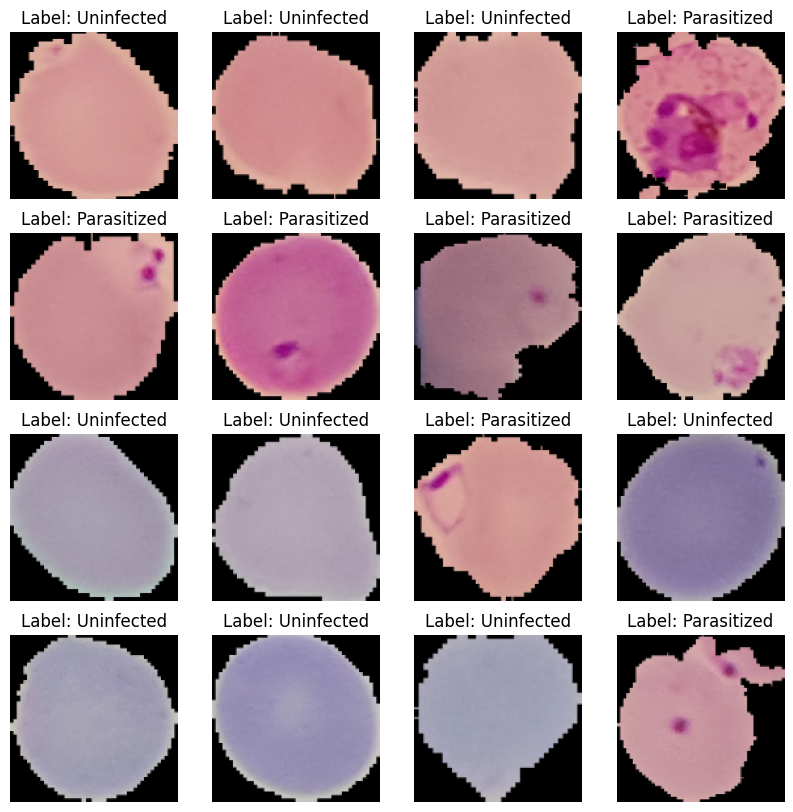

In [15]:
show_sample_images_from_dataset(X_train, y_train)

In [16]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [17]:
def create_vgg16_base_model(input_shape, verbose=0):
    vgg = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= input_shape)

    #for layer in vgg.layers[:-8]:  #Set block4 and block5 to be trainable.
    if verbose > 0:
        print("Non-trainable layers: ")
    for layer in vgg.layers[:-5]:    #Set block5 trainable, all others as non-trainable
        if verbose > 0:
          print(layer.name)
        layer.trainable = False # All others as non-trainable.

    x = vgg.output
    x = GlobalAveragePooling2D()(x) # Use GlobalAveragePooling and NOT flatten.
    x = Dense(2, activation="softmax")(x)  # We are defining this as multiclass problem.

    return Model(vgg.input, x)

In [18]:
model = create_vgg16_base_model(experiment['INPUT_SHAPE'])
print(model.summary())

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [19]:
model.compile(loss = "categorical_crossentropy",
                  optimizer = SGD(learning_rate=0.0001, momentum=0.9), metrics=["accuracy"])

In [20]:
history = model.fit(X_train, y_train, batch_size=experiment['BATCH_SIZE'], epochs=5, verbose = 1,
                    validation_data=(X_test, y_test))

Epoch 1/5
625/625 [==============================] - 27s 35ms/step - loss: 0.3365 - accuracy: 0.8717 - val_loss: 0.1856 - val_accuracy: 0.9330
Epoch 2/5
625/625 [==============================] - 20s 32ms/step - loss: 0.1740 - accuracy: 0.9389 - val_loss: 0.1518 - val_accuracy: 0.9360
Epoch 3/5
625/625 [==============================] - 21s 33ms/step - loss: 0.1531 - accuracy: 0.9470 - val_loss: 0.1250 - val_accuracy: 0.9550
Epoch 4/5
625/625 [==============================] - 20s 33ms/step - loss: 0.1435 - accuracy: 0.9507 - val_loss: 0.1153 - val_accuracy: 0.9660
Epoch 5/5
625/625 [==============================] - 21s 33ms/step - loss: 0.1397 - accuracy: 0.9527 - val_loss: 0.1102 - val_accuracy: 0.9660


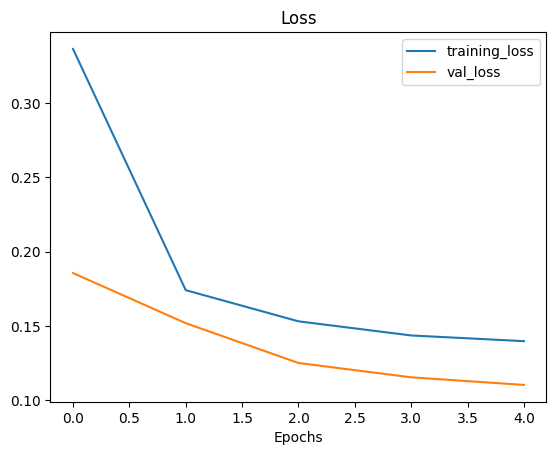

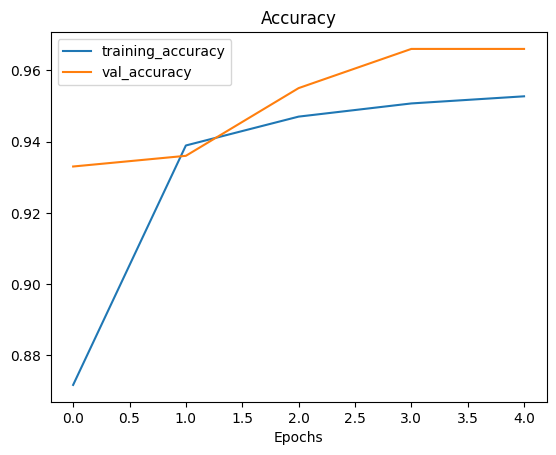

In [21]:
vision.plot_loss_curves(history, all_in_one=False)

In [22]:
loss, acc = model.evaluate(X_test, y_test)

print("Accuracy = ", (acc * 100.0), "%")

32/32 [==============================] - 4s 41ms/step - loss: 0.1102 - accuracy: 0.9660
Accuracy =  96.60000205039978 %


1/1 [==============================] - 1s 1s/step
The prediction result for 1.test image : 1 - Parasitized


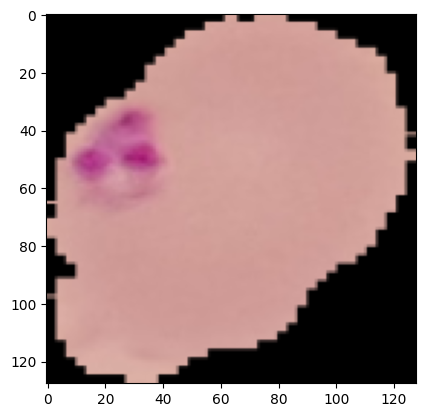

In [23]:
ix = 1
plt.imshow(X_test[ix])

input_img = np.expand_dims(X_test[ix], axis=0)

print(f"The prediction result for {ix}.test image : {np.argmax(model.predict(input_img))} - {LABELS[np.argmax(y_test[ix])]}", )

In [24]:
y_pred = np.argmax(model.predict(X_test), axis=1)


32/32 [==============================] - 1s 39ms/step


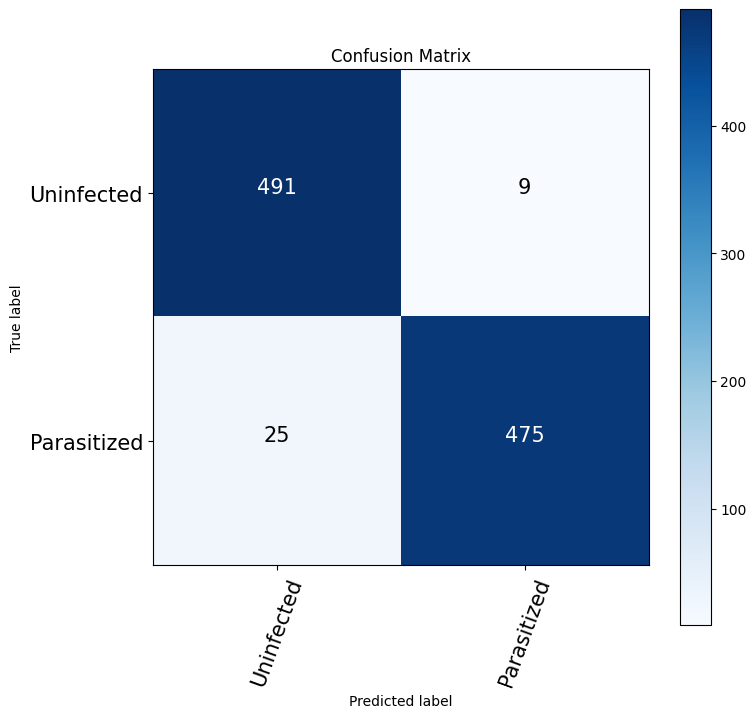

In [25]:
vision.show_confusion_matrix(np.argmax(y_test, axis=1), y_pred, LABELS, figsize=(8,8))

In [26]:
parasited_image_idx = np.where(y_pred == 1)[0]

parasited = [X_test[ix] for ix in parasited_image_idx]

In [27]:
parasited = np.array(parasited)

In [105]:
from matplotlib.patches import Rectangle # To add a rectangle overlay to the image
from skimage.feature.peak import peak_local_max  # To detect hotspots in 2D images.

def build_heatmap(model, img, last_conv_layer=None, verbose=0):
    # Find last convolutional layer if not specified
    if last_conv_layer == None:
        for layer in reversed(model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                last_conv_layer = layer.name
                break
        if last_conv_layer == None:
            # otherwise, we could not find a 4D layer
            raise ValueError("Could not find 4D layer. Cannot build Heatmap.")

    # Get output from the last conv. layer
    last_conv_model = Model(model.input, model.get_layer(last_conv_layer).output)
    if len(img.shape) == 4:  # If Input image is already shaped as (1,W,H,C)
        pred = model.predict(img)
        last_conv_output = last_conv_model.predict(img)
    elif len(img.shape) == 3:  # If Input image is shaped as (W,H,C), expected (None,W,H,C)
        pred = model.predict(np.expand_dims(img, axis=0))
        last_conv_output = last_conv_model.predict(img[np.newaxis,:,:,:])
    else:
        raise ValueError("Input image shape error.")

    pred_class = np.argmax(pred)

    # Get weights for all classes from the prediction layer
    last_layer_weights = model.layers[-1].get_weights()[0] # Prediction layer

    #Get weights for the predicted class.
    last_layer_weights_for_pred = last_layer_weights[:, pred_class]

    last_conv_output = np.squeeze(last_conv_output)  # Output shape: (W,H,C)

    # Upsample/resize the last conv. output to same size as original image
    h = int(img.shape[0] / last_conv_output.shape[0])
    w = int(img.shape[1] / last_conv_output.shape[1])
    upsampled_last_conv_output = scipy.ndimage.zoom(last_conv_output, (h, w, 1), order=1)

    #last_conv_output = np.expand_dims(last_conv_output, axis=0)
    #upsampled_last_conv_output = tf.keras.layers.UpSampling2D(size=(h, w))(last_conv_output)
    #upsampled_last_conv_output = np.squeeze(upsampled_last_conv_output)  # Output shape: (W,H,C)

    if verbose > 0:
      print(f"Last convolutional layer output shape: {last_conv_output.shape}")
      print(f"Last convolutional layer output shape after upsampling: {upsampled_last_conv_output.shape}")

    heat_map = np.dot(upsampled_last_conv_output.reshape((img.shape[0]*img.shape[1], upsampled_last_conv_output.shape[-1])),
                 last_layer_weights_for_pred).reshape(img.shape[0],img.shape[1])

    # Since we have a lot of dark pixels where the edges may be thought of as
    # high anomaly, let us drop all heat map values in this region to 0.
    # This is an optional step based on the image.
    heat_map[img[:,:,0] == 0] = 0  #All dark pixels outside the object set to 0

    # Detect peaks (hot spots) in the heat map. We will set it to detect maximum 5 peaks.
    # with rel threshold of 0.5 (compared to the max peak).
    peak_coords = peak_local_max(heat_map, num_peaks=5, threshold_rel=0.5, min_distance=10)

    return heat_map

    #for i in range(0, peak_coords.shape[0]):
    #    print(i)
    #    y = peak_coords[i,0]
    #    x = peak_coords[i,1]
    #    plt.gca().add_patch(Rectangle((x-25, y-25), 50,50,linewidth=1,edgecolor='r',facecolor='none'))

1/1 [==============================] - 0s 18ms/step


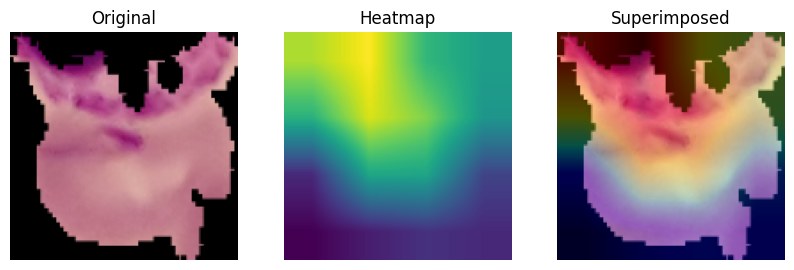

In [93]:
ix = 9

gradCAM = vision.GradCAM(model)
class_id = np.argmax(model.predict(np.expand_dims(parasited[ix], axis=0))[0])

(heatmap, output) = gradCAM(np.expand_dims(parasited[ix], axis=0), parasited[ix]*255, class_id, alpha=0.4)

fig = plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(parasited[ix])
plt.title("Original")
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(heatmap)
plt.title("Heatmap")
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(output)
plt.title("Superimposed")
plt.axis('off')
plt.show()

1/1 [==============================] - 0s 124ms/step
Last convolutional layer output shape: (4, 4, 512)
Last convolutional layer output shape after upsampling: (128, 128, 512)


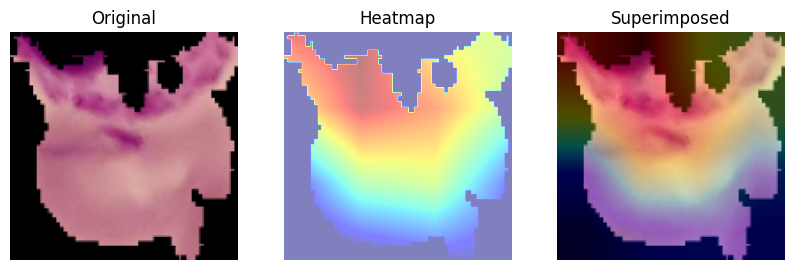

In [106]:
#import random
#ix = random.randint(0, parasited.shape[0]-1)
ix = 9
heat_map = build_heatmap(model, parasited[ix], verbose=1)

fig = plt.figure(figsize=(10,10))
plt.subplot(1,3,1)
plt.imshow(parasited[ix])
plt.title("Original")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(heat_map, cmap='jet', alpha=0.50)
plt.title("Heatmap")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(output)
plt.title("Superimposed")
plt.axis('off')
plt.show()

#img = parasited[im]
#plt.imshow(parasited[im])

Reference:

https://github.com/bnsreenu/python_for_microscopists/blob/master/262_localizing_anomalies_in_images/262_localizing_anomalies_in_images.py